In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import sys
import numpy as np
import csv
import cv2
import argparse 
import imageio
from skimage.filters import threshold_otsu, threshold_mean, threshold_local, threshold_isodata
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import square
from skimage import morphology
from skimage.segmentation import clear_border
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

/var/folders/sd/z_kvtl2s6v93h4_t4j4zmpjm0000gn/T/ipykernel_70879/1302256054.py:15: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


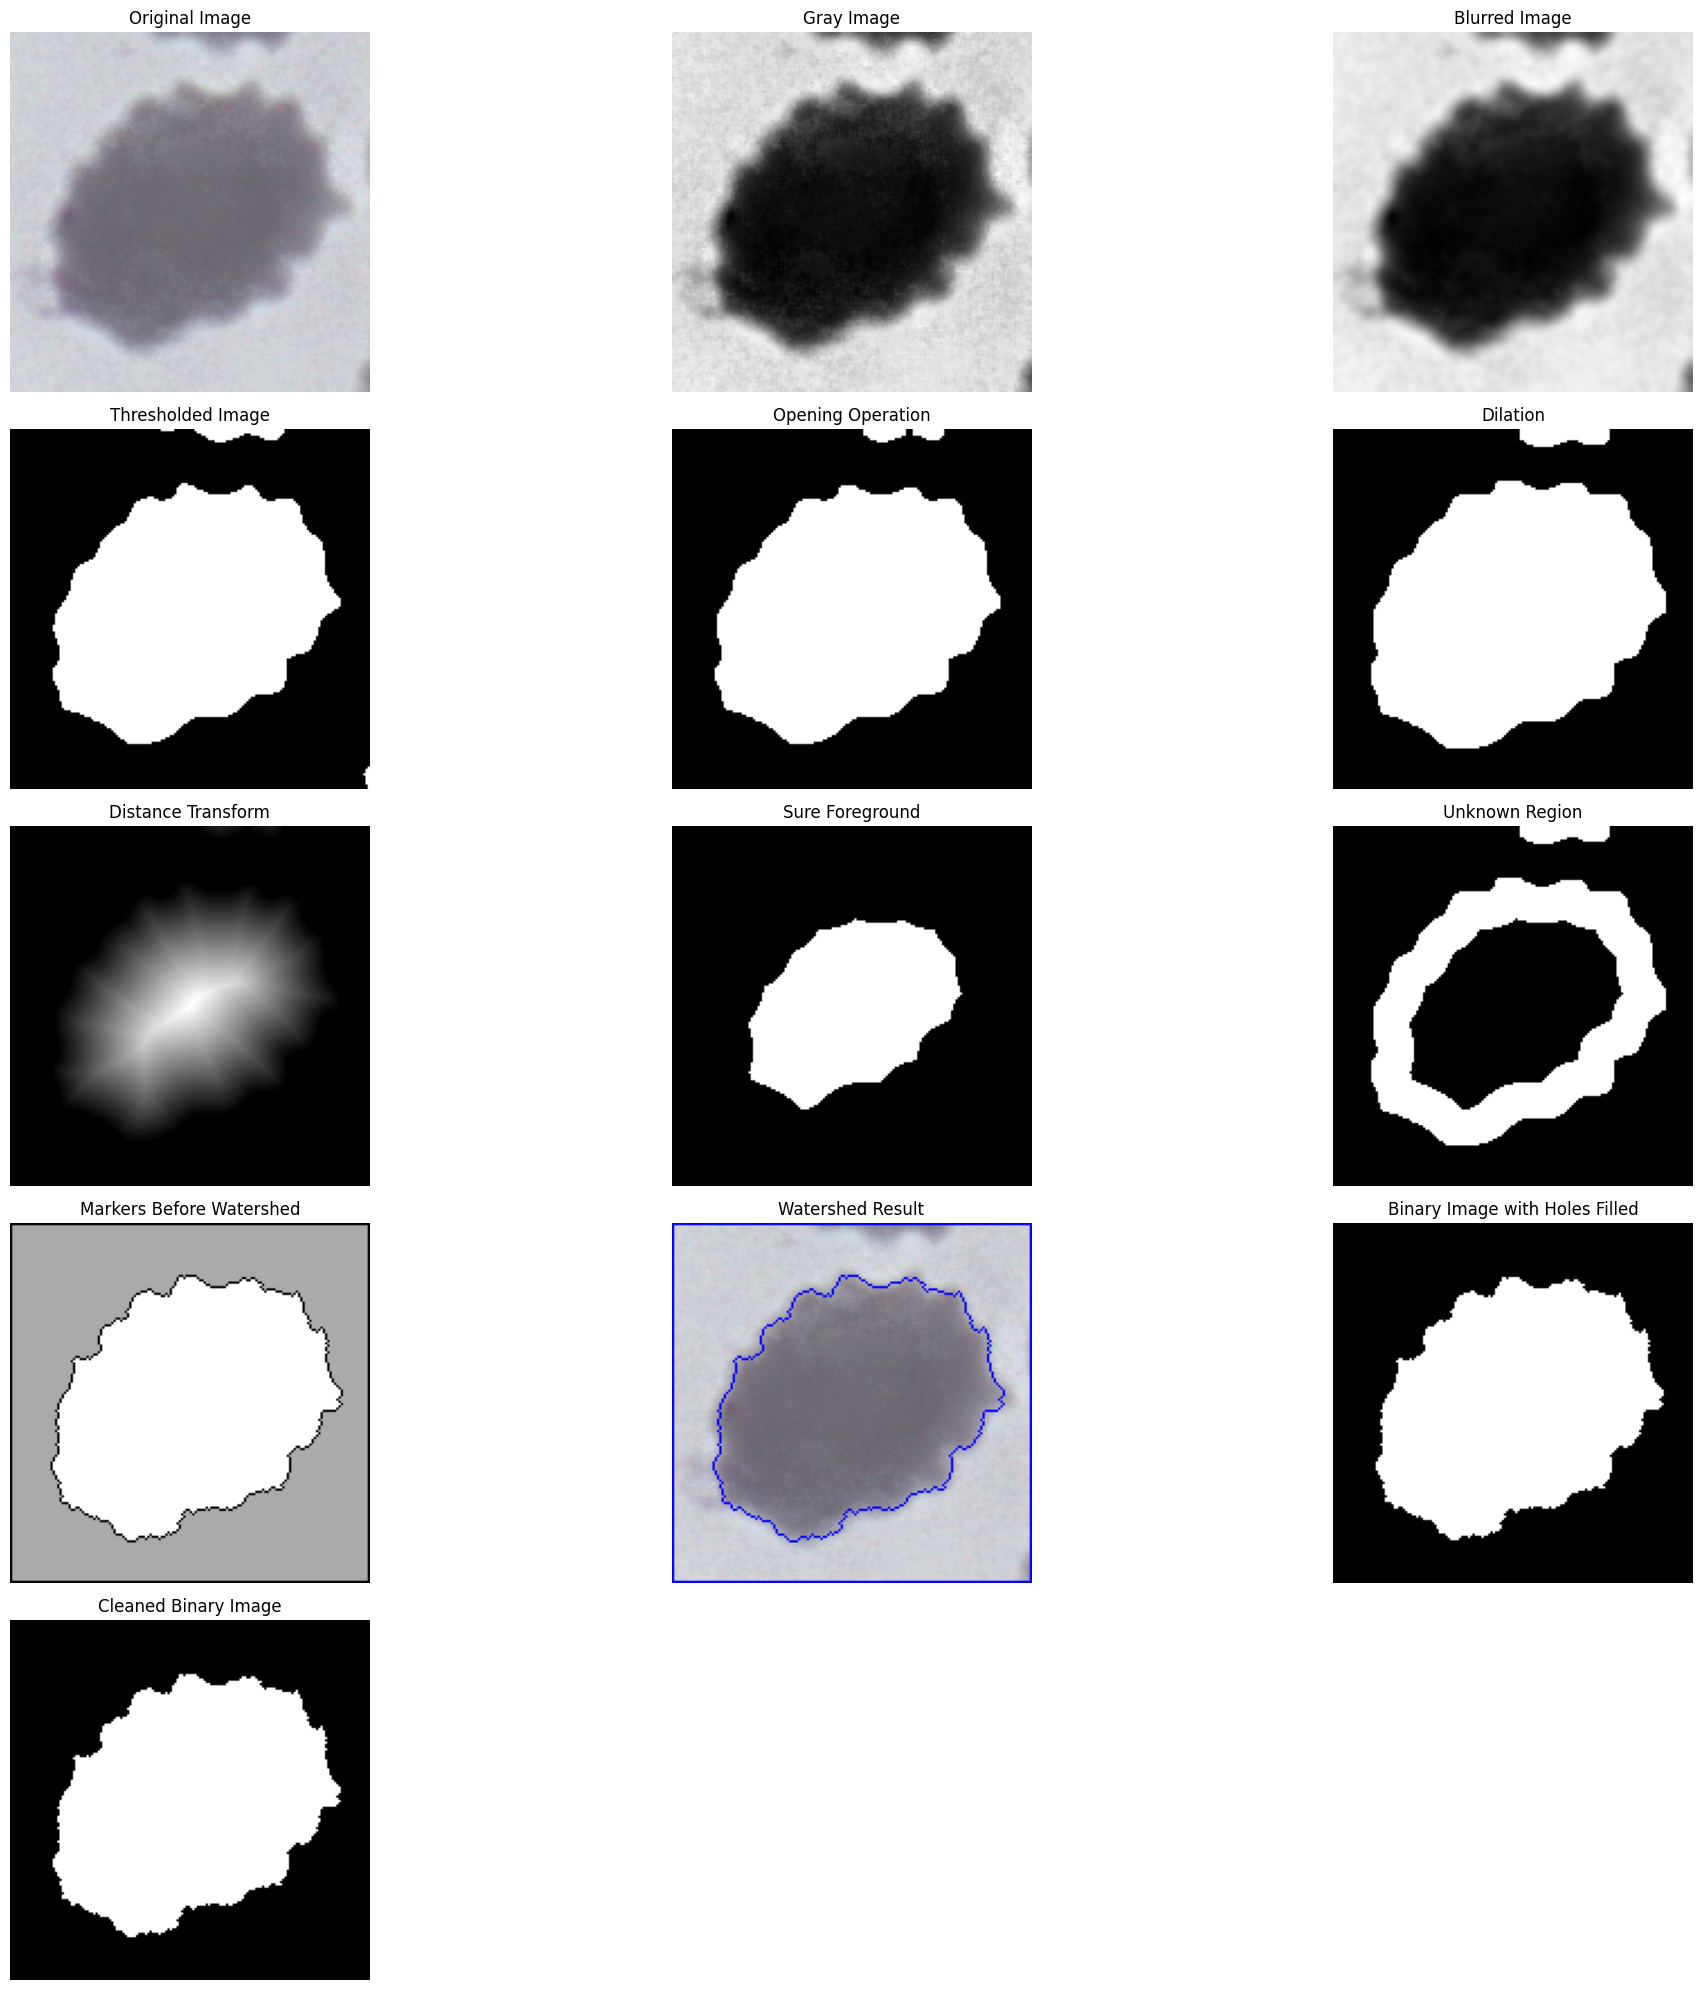

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage import morphology

# Set your image path
image_path = 'RCM_cells_cleaned/sma/130218-01/23.png'

def visualize_image(img, title="Image"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage import morphology


# Set up a list to store images and their titles
images_to_show = []
titles_to_show = []

def add_to_plot(img, title):
    images_to_show.append(img)
    titles_to_show.append(title)

# Read the image
image = cv2.imread(image_path)

# Set up a list to store images and their titles
images_to_show = []
titles_to_show = []

def add_to_plot(img, title):
    images_to_show.append(img)
    titles_to_show.append(title)

# Add original image
add_to_plot(image, "Original Image")

# Convert to Gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
add_to_plot(gray, "Gray Image")

# Gaussian Blur
gray_blurred = cv2.GaussianBlur(gray, (5,5), 0)
add_to_plot(gray_blurred, "Blurred Image")

# Thresholding
ret, thresh = cv2.threshold(gray_blurred, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
add_to_plot(thresh, "Thresholded Image")

# Opening
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
add_to_plot(opening, "Opening Operation")

# Dilation
sure_bg = cv2.dilate(opening, kernel, iterations=2)
add_to_plot(sure_bg, "Dilation")

# Distance Transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
add_to_plot(dist_transform, "Distance Transform")

# Thresholding for foreground
ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
add_to_plot(sure_fg, "Sure Foreground")

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
add_to_plot(unknown, "Unknown Region")

# Connected Components to differentiate regions
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
add_to_plot(markers, "Markers Before Watershed")

# Watershed
markers = cv2.watershed(image, markers)
image_with_markers = image.copy()
image_with_markers[markers == -1] = [255, 0, 0]
add_to_plot(image_with_markers, "Watershed Result")

# Convert markers to binary and fill holes
bw = (markers > 1).astype(int)
bw_filled = binary_fill_holes(bw).astype(np.uint8)
add_to_plot(bw_filled * 255, "Binary Image with Holes Filled")

# Remove small objects
bw_clean = morphology.remove_small_objects(bw_filled.astype(bool), min_size=5000, connectivity=4).astype(np.uint8)
add_to_plot(bw_clean * 255, "Cleaned Binary Image")

# Display all images in one plot
def display_all_in_one_plot(images, titles):
    n = len(images)
    cols = 3  
    rows = n // cols 
    rows += n % cols
    position = range(1, n + 1)

    plt.figure(figsize=(20, 20))
    for k, (img, title) in enumerate(zip(images, titles)):
        ax = plt.subplot(rows, cols, position[k])
        if len(img.shape) == 2:  # grayscale image
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_all_in_one_plot(images_to_show, titles_to_show)